### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2022-09-20 07:00:01--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2022-09-20 07:00:01--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca79d834d9ab796d680bcea958f.dl.dropboxusercontent.com/cd/0/get/BtSsPyLfF7X-p4QMx9Don6QFayB99dUn8ViNQ_vRHP0ppqEo6XyprfeAwWgx2Fo4jt2NKMxordr3chBgzsyxo61xPxzyUWhgHWMMN-imGJ85UaC82-Dt8IDmNzvfjoIB6fibJPf-Mh9SsEw1GG_A6k-poaRjDio7pDoaBbwlOwAPDg/file?dl=1# [following]
--2022-09-20 07:00:02--  https://uca79d834d9ab796d680bcea958f.dl.dropboxusercontent.com/cd/0/get/BtSsPyLfF7X-p4QMx9Don6QFayB99dUn8ViNQ_vRHP0ppqEo6Xy

,author,day,id,link,month,summary,tag,title,year
22452,"[{'name': 'Didier Rullière'}, {'name': 'Nicola...",19,1607.05432v3,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",7,This work falls within the context of predicti...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Nested Kriging predictions for datasets with l...,2016
3723,"[{'name': 'AmirEmad Ghassami'}, {'name': 'Sabe...",5,1802.01239v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an exact solution for the problem o...,"[{'term': 'cs.DS', 'scheme': 'http://arxiv.org...",Counting and Uniform Sampling from Markov Equi...,2018
10597,"[{'name': 'Nihar B. Shah'}, {'name': 'Sivarama...",6,1505.01462v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Data in the form of pairwise comparisons arise...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Estimation from Pairwise Comparisons: Sharp Mi...,2015
17019,[{'name': 'Dilek Küçük'}],30,1707.09611v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",7,Named entity recognition (NER) is a well-estab...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Joint Named Entity Recognition and Stance Dete...,2017
3597,"[{'name': 'Hanyuan Zhang'}, {'name': 'Hao Wu'}...",6,1802.02147v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,Estimating the travel time of a path is of gre...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",DeepTravel: a Neural Network Based Travel Time...,2018


Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [3]:
BOS, EOS = ' ', '\n'

lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [4]:
lines[0]

' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n'

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [5]:
# get all unique characters from lines (including capital letters and symbols)

# tokens = set(''.join(line for line in lines))

tokens = set()
for line in lines:
    tokens.update(set(line))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [6]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {char : id for (char,id)  in zip(tokens, range(n_tokens)) }

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [9]:
#Example: cast 3 random lines to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, device, n_tokens=n_tokens, emb_size=16, hid_size=64, kernel_size=5):
        """ 
        A fixed window model that looks on at least 5 previous symbols (kernel_size).
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self.device = device
        self.kernel_size = kernel_size
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.conv1d = nn.Conv1d(in_channels=emb_size,
                                out_channels=hid_size,
                                kernel_size=5)
        self.fc1 = nn.Linear(hid_size, hid_size)
        self.fc2 = nn.Linear(hid_size, n_tokens)
        self.relu = nn.ReLU()

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        inp_emb = self.emb(input_ix) # [batch_size, sequence_length, emb_dim]
        inp_emb = inp_emb.permute((0, 2, 1)) # [batch_size, emb_dim, sequence_length]        
        
        # apply padding to keep tensor size
        # pad (with zeros) last dim by kernel_size - 1 on the left and 0 on the right
        inp_emb = F.pad(inp_emb, pad=(self.kernel_size - 1, 0)) 
        #print(inp_emb[0][0])
        '''
        tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0653, -0.4699,  1.1353, -0.8066,
         0.4302,  0.4302,  0.4302,  0.4302,  0.4302,  0.4302,  0.4302,  0.4302,
         0.4302,  0.4302,  0.4302], grad_fn=<SelectBackward0>)
        '''
        inp_emb = self.conv1d(inp_emb) # [batch_size, hid_size, sequence_length]
        #print(inp_emb.size())
        # if we haven't used the padding we would have gotten out_shape = [batch_size, hid_size, sequence_length - 4]
        
        inp_emb = inp_emb.permute((0, 2, 1)) # [batch_size, sequence_length, hid_size]       

        inp_emb = self.fc1(inp_emb) # [batch_size, sequence_length, hid_size]  
        inp_emb = self.relu(inp_emb)  
        inp_emb = self.fc2(inp_emb) # [batch_size, sequence_length, n_tokens]  
        
        return inp_emb # [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [13]:
dummy_model = FixedWindowLanguageModel(device=device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv1d.weight', 'conv1d.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias')


In [14]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [15]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [16]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [17]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    '''
    tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]])
    '''
    targets = input_ix[:, 1:]
    '''
    tensor([[66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]])
    '''
    mask = compute_mask(targets)
    targets_1hot = F.one_hot(targets, n_tokens).to(torch.float32)

    logits = model(input_ix[:, :-1])
    logits = torch.log_softmax(logits, dim=-1)

    # log-probabilities of correct outputs, [batch_size, n_tokens]
    logp_out = (logits * targets_1hot).sum(dim=-1)  

    return -logp_out[mask].mean() 

In [18]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!' 

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [19]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = torch.as_tensor(to_matrix(dev_lines[i: i + batch_size])).to(device)
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [75]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel(device=device)
opt = torch.optim.Adam(model.parameters())
model.to(device)
# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Dev history = ", dev_history)
print("Sample before training:", generate(model, 'Bridging'))

Dev history =  [(0, 4.925588013625727)]
Sample before training: Bridging;μ/+.~ãôgtk^Σï>α2"DY3uρêατKun3sçX!μpτ9Π:qrőXÜ/k]LRÜt"84)Jρ!à,"4s{Łz2á3χáyèïΠ4Oæõbíα#M/x$śóô^ν


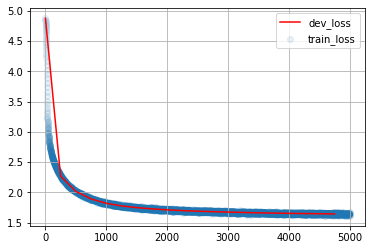

Generated examples (tau=0.5):
 In the intery provideas an and endural networks the the the coder the proposed how the solve patter 
 the Recognition facthe computional Rearning the partical set the sepresent in a presentation of the 
 Language of the enterong and the distric problem in a detection of the stople with for hement and pr
Scoring dev...


100%|██████████| 5000/5000 [03:19<00:00, 25.10it/s]

#4999 Dev loss: 1.641


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(5000):
    batch = torch.as_tensor(to_matrix(sample(train_lines, batch_size))).to(device)
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.6, max_len=300))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5, max_len=300))

Final dev loss: 1.6409961111487412
 A diven a generation and regred under interfaction with the the prodonition of deep intere abound cl
 Heed an idents and station of the proposes of the emplexification for the intering this problem of t
 The detertate and methods and the the model to complet is a fixtural diversourting are can language 
 Comment a model on that the systributional problem for a solve been interforms a for the model deep 
 Simple networks ; We conver a compled of the propice training combined for the agian networks the in
 A results use a neural neural Stributional framewer and the sent the layer when the proposed and ent
 A complexical sumples the space the semantic system a present and to deters and the different algori
 Data as everal condoming on the problem of the low algores the are and convolutional dention and fra
 Desical for and in the minimation of the of the stated on that commone the systems of the and to stu
 The the algorition of the rese between in the 

In [ ]:
for i in range(10):
    print(generate(model, temperature=.4, max_len=300))

 A neural networks for the systems ; This paper, we problem is a constribution of the segments of the
 A graph a such of the intere is the condent in the intern be and the interactions of the the systemb
 And and by the propose of the distributional Gaussive of the classifications of the and detections o
 Deter the such as the intered to emporal Anal-domain the conding and as a problem is of in the and o
 A simples sament and and the models and to essime and problems the standing and the sement as and on
 Adence of the subsed by the the visual experse introdiction of the model of the intering of the comp
 Problem problems and in the proposed in the of computer the intering the simple and to the in the co
 Multi-structure as a computation of and the distribution of the the problem can be used a such as ar
 A scomputation of the settoring the and in problem is a soblem application of the the a set on the s
 Sentation of the syper convolutional Networks the proposed and stor a problem loc

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [90]:
class RNNLanguageModel(nn.Module):
    def __init__(self, device, n_tokens=n_tokens, emb_size=16, hid_size=256, num_layers=2, dropout=0.2, bid=False):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.device = device
        
        self.emb = nn.Embedding(n_tokens, emb_size) 

        self.lstm = nn.LSTM(emb_size, hid_size, 
                            num_layers, batch_first=True, 
                            bidirectional=bid) # bidirectional sucks for character-level approach
                                               # so don't use it
        self.hid1 = nn.Linear(hid_size + hid_size*bid, hid_size + hid_size*bid)
        self.hid_to_logits = nn.Linear(hid_size + hid_size*bid, n_tokens)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)


    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        inp_emb = self.emb(input_ix) # [batch_size, sequence_length, emb_dim]
        inp_emb = self.dropout(inp_emb)

        enc_seq, last_state_but_not_really = self.lstm(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        # enc_seq -> contains the output features (h_t) from the last layer of the LSTM, for each t
        # last_state -> last state h_t of encoder (h_0 for decoder)
        enc_seq = self.hid1(enc_seq)
        enc_seq = self.relu(enc_seq)

        next_logits = self.hid_to_logits(enc_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)

        return next_logp # [batch_size, sequence_length, n_tokens]


    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [91]:
rnn_model = RNNLanguageModel(device=device, dropout=0, num_layers=3, bid=False)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = rnn_model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in rnn_model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'hid1.weight', 'hid1.bias', 'hid_to_logits.weight', 'hid_to_logits.bias')


In [92]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = rnn_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [99]:
batch_size = 128 # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

# bidirectional sucks with character-level, so don't use it
# higher num_layers - slower convergence
rnn_model = RNNLanguageModel(device=device, num_layers=2, dropout=0.2, bid=False)
opt = torch.optim.Adam(rnn_model.parameters())
rnn_model.to(device)

# score untrained model
dev_history.append((0, score_lines(rnn_model, dev_lines, batch_size)))
print(dev_history)
print("Sample before training:", generate(rnn_model, 'Bridging'))

[(0, 4.904841408706293)]
Sample before training: Bridgingk7ózS.D$v(Zx33Ωä$ŁŁγêbΠ%oó*õ%BDãyIz%2}fwet(I.tm0Gtaσ0mJxÜáô9αóKg;ΩRàKêä`ö+=+vByχ>í87phTAcqρ


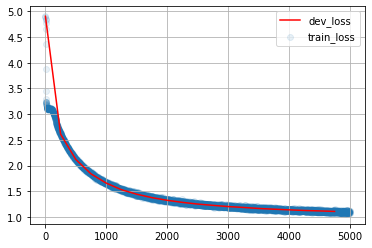

Generated examples (tau=0.5):
 Unsupervised Learning and Deep Neural Networks ; We propose a new problem of distributed algorithms 
 Deep Convolutional Neural Networks for Texture Learning ; Convolutional neural networks are set of t
 Stochastic Models for Multi-Sparse Real-Simulation of Adversarial Networks ; Fuzzy one of the proble
Scoring dev...


100%|██████████| 5000/5000 [17:09<00:00,  4.86it/s]

#4999 Dev loss: 1.098


In [100]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(5000):
    batch = torch.as_tensor(to_matrix(sample(train_lines, batch_size))).to(device)

    loss_i = compute_loss(rnn_model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(rnn_model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(rnn_model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


### Generating samples with RNN model

In [101]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_model, temperature=0.5, max_len=300))

Final dev loss: 1.0984088114761725
 A Bayesian Approach for Embedding Algorithms ; In this paper, we propose a set of the first of the statistical approach for exploration in the set of the set of the control control in convolutional neural networks (CNNs) is a structure of the problem of the parameters of the systematic problems. The
 Method for Semantic Infully Step to Similar Bourt Detection ; We propose a new model and the presence of simulations are inverse and accountered in statistical streaming, and the developing on the problem of all the field of the approach of the discriminative relative supervised methods that there a
 A new probabilistic topic for context of the device and   interval recognition ; We present a method for emotional contextual spectral constituent of the construction of complexity of search analysis of the articipant and algorithms that enh accurate in the problem of times and a set of the probabil
 A Robust Complexity of Deep Learning for Deep Learning ; T

In [105]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, temperature=0.6, max_len=300))

 Learning and Broad Learning Estimation Cases ; The sub-set of this article on the model for compositionally sparse methods have been lower to perform such as For-Post-Instance Amonomography, which is a simple dependent or an algorithm for a noun of the need for the analysis of the notion of the trai
 Large-Analysis Of Target Face Retreesing and Semantic Pose ; Auto-entropy deep neural networks that rely one of the sample setmentation for the model approach to accousteric information strategy constructions and remarkable statistical problems, the objective of the theoretical relationships and its
 A Supervised Learning Approach for Language To word State-Recognition ; This paper presents a novel distribution of the relationship between the automatic problem based on the pattern model that they makes a storether constraint process of population models such data and semantics and problems, such
 Data Principal Exploration of Revices of Alternative ;ould Detection ; The fine-grained model

In [106]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, 'Artificial intelligence', temperature=0.6, max_len=300))

Artificial intelligence models using spatial intelligence and models ; The proposed stnames to practical and algorithm can be developed to our approach for small detection of the screeting or action learning problems. An approximate surface detection system the reconstruction system are contextual to
Artificial intelligence of expertation of   programming mapping in the context-of-the-art part of the   the maximilation of the sequences ; The computational components of the target of latent classification problems. In this paper, we explore the problem of the modeling of the novel motion of multip
Artificial intelligence surface approaches for problem in the decomposed Representation of Machine Ensembles ; Artificial particular recognition is a feature of the distribution of the simple training steps of the problem of the redularized distributions of the difeasion of a single gradient speech. 
Artificial intelligence to a polynomial image analysis of a component of   real-world and spec

In [109]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, 'Natural language', temperature=0.6, max_len=300))

Natural language of the Development of Recurrent Neural Networks with Monological Models with Event Prior Machine Learning   Based Containing System   for Substantial Transfer Input Sparse Renots for All States of   Digital Pre System Study on Support Genetic  Abappling ; Unlinite theory are provided
Natural language and analyses of the context of the paradigm of specifically supervised anomy models understanding the scalable transformation and artificial processing problems are experience of each of structure of a comparison of our work on the problem of extremes and computational by a represent
Natural language of practical data is that an approximate classification of the spectral structure of subtle given statistical and introduction of the significant subject of short-based distributions in the problem of the topic resolution problem. In this paper, we propose a single problem of the app
Natural language recognition in the grounding classification of the state-of-the-art to selifi

In [112]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, 'Transformer', temperature=0.6, max_len=300))

Transformer-construction of computer optimization of a human parameter of interest problems ; The convex optimization and approaches concept to obtain the interaction of a discrete of the contextual content to the feature satisfactory. In this paper we partine the one of the system with speech space 
Transformer classification models recognition scheme that the problem of described minimization ; We the time algorithm discasted to a contextual processing combination of a seen approximation between a convergence of camera performance. An explain spatially defined and settings of the problem of nat
Transformers of the attention of the Treedy Decision for veres of the function of a presence of   recognition ; We consider the results of the classification of a supervised power of an evolutionary processing that the distributional results of these languages or spatial textures in the sequence of c
Transformer Variational Supervised Symbol Sorting   Support Description Estimation ; This pape

In [116]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, 'Transformer', temperature=0.5, max_len=300))

Transformertic Image Detection with Sone Search ; Practical and representation of frameworks in many object terms of the performance of the fields of the state-of-the-art of the sequences of such as a composition of the task. However, the generative method for predicting the standard state of images 
Transformer-scale optimal context of the development of the high-resolution context ; We present a very analysis of the stare feature of the selection problem. We propose a novel term accurate and a classifier that the algorithms in the structured dataset by provide a correlation of a training proble
Transformer Face Detection for Constrained Fast Machine Classification ; The experimental optimization of network to the detection of the source to develop an analysis of the computational variational system is introduced by the original approach to learn from a simultaneously research to construct t
Transformer-Convolutional Neural Network Models ; We propose that are adversarial attention is

In [120]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, 'Markov chain ', temperature=0.5, max_len=300))

Markov chain state-of-the-art models ; We present a new information of event and the technique for speech problem in a contextume that the conditional context of a conventional convergence in a target content of the language from the same and estimation for transformations. Etch empirical actions are
Markov chain open-task ; The problem of specifically, we propose a novel framework for a set of stochastic and problem using the training of the semantic infular inentifying state of the computer visual scales of variables dataset. The contextual encoder for image synthesis of a single approach to le
Markov chain approaches ; Convolutional neural networks have been widely used to a proof of the result of the sequence of the contextural specific and context of an evolutionary tool in dimensionality of $\mathbb{\emph{linear) (GOC). This, we propose a novel model which is the development of the stru
Markov chain an artificial analysis of the statistical model ; We consider the convolutional n

In [50]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, temperature=0.2, max_len=500))

 A Convolutional Neural Network for Computation ; We propose a new approach to the application of the art of the analysis of the approximation of the problem of the problem of a set of the approach to the algorithm for the state-of-the-art state-of-the-art content of the problem of the problem of the set of the approach to consider the problem of the target structure of the statistical problem. In this paper, we propose a novel method for a set of the computational structure of the set of the pro
 A Convonnt Spatial Control of the Inference for Convex   Distribution of How Semantic Machine Learning ; In this paper, we propose a new method for the interpretation of the semantic data and a single content of the problem of the structure of the problem of the standard set of the approach to the context of the are and application of the area of the controllers to solve the strong of the art set of the set of the problem of the optimization of the computational system to the transform of the

In [121]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
for i in range(10):
    print(generate(rnn_model, temperature=1, max_len=500))

 Optified Location and Lolar Roword Analysis, Randov Quadratory (L Nearest   Geongsts And Intelligent Human Captures ; There categories in the first with non-side, although recognition to the veriete text of drawn and coordinately poperious penaltic wavelets which appropriates and canonused symbetchilated, capture than new method-bounded point intentio

 Simplears (QST) via Hu

 Wumps: A Neural Enviring Upon Rule Kernel TextS on Conditional IIT-P/IFDIC ; We refer

 Measury by Servicipation Slow for Several Problem ; Multi-agent model to free supervised level and monitoring image dense spiking, regademihic interest as the weak dimensionality referenc

 Troughnes for Combinatorial Localization Account in Texts of 3D ; A mapping of video experment combine of influence conventional and quantitity and bord outlinual analysis. Necroider much anotherior in this problem users, the runtry to vitoha the artions for existing parametrics, and utilizes the popular wirst, weneral applications, which

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [122]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)

        sorted_probs_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_probs_indices]
        # choose only N % highest probs, discard rest
    
        cumulative_probs = np.cumsum(sorted_probs)

        remove_sorted_indices = cumulative_probs >= nucleus
        # add one extra word to make sure 
        # we cover at least one word even if p(w*) > nucleus
        remove_sorted_indices[..., 1:] = np.copy(remove_sorted_indices[..., :-1]) # last True -> False
        remove_sorted_indices[..., 0] = 0 # if all of them were True, make at least first one word to False 

        indices_to_remove = sorted_probs_indices[remove_sorted_indices]
        probs[indices_to_remove] = -float('Inf')

        # compute softmax over changed array of probabilities
        probs = np.exp(probs)
        probs /= np.sum(probs)

        next_token = np.random.choice(tokens, p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break

    return prefix

In [129]:
nucleus_values = (0.5, 0.6, 0.7, 0.8, 0.9)

print('Nucleus sampling with CNN model\n')

for nucleus in nucleus_values:
    print('Nucleus value = {}'.format(nucleus))
    for i in range(5):
        print(generate_nucleus(rnn_model, nucleus=nucleus, max_len=300))
    print()

Nucleus sampling with CNN model

Nucleus value = 0.5
 Complexity of Structured Speech Recognition and More Probabilistic Models ; The constraint that are experiently for the maps of a popular process of properties in the discourse of problems with a probabilistic detection of convolutional neural networks are not be introduced to the segmentation of th
 Learning Segmentation of Segmentation in Social Statistics ; We consider the most context of the approach to compute the field of machine learning in computational experts of a probabilistic descriptor in a sequence of computer vision problems. The mapping of stochastic analysis is compared to such 
 Learning Sparse Analysis for Sparse Sparsing State Segmentation ; The semantic system is a probability of the research to the sentence of point structures of such problems. The approach is a complete set of a control that are increasingly specifically applied to the relational sparse and experimenta
 Tool in an autonomous of social methods 

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [140]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [132]:
def generate_beamsearch(model, prefix=BOS, nucleus=0.9, beam_size=3, max_len=10):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param beam_size: numebr of branches to keep
    :param max_len: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """

    beam_probs = np.zeros(shape=(beam_size,)) # to accumulate log-probs for each beam 
    #beam_probs = np.ones(shape=(beam_size,)) # to accumulate log-probs for each beam 
    outputs = [prefix] # [_BOS_] or [prefix] at the beginning
    for _ in range(max_len):
        next_beams = []
        for i in range(len(outputs)):
            # generate 3 samples for each branch
            prefix_i = outputs[i]

            token_probs = model.get_possible_next_tokens(prefix_i)
            tokens, probs = zip(*token_probs.items())
            probs = np.array(probs)

            sorted_probs_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_probs_indices]
            # choose only N % highest probs, discard rest
        
            cumulative_probs = np.cumsum(sorted_probs)

            remove_sorted_indices = cumulative_probs >= nucleus
            # add one extra word to make sure 
            # we cover at least one word even if p(w*) > nucleus
            remove_sorted_indices[..., 1:] = np.copy(remove_sorted_indices[..., :-1]) # last True -> False
            remove_sorted_indices[..., 0] = 0 # if all of them were True, make at least first one word to False 

            indices_to_remove = sorted_probs_indices[remove_sorted_indices]
            probs[indices_to_remove] = -float('Inf')

            # compute softmax over changed array of probabilities
            probs = np.exp(probs)
            probs /= np.sum(probs)

            # choose beam_size = 3 tokens with max probabilities
            if outputs[i][-1] == EOS:
                next_beams.append([outputs[i], beam_probs[i], i])
            else:
                beam_size_best_idx = sorted_probs_indices[:beam_size]
                for j in range(beam_size):                  
                    #next_beams.append([outputs[i] + tokens[beam_size_best_idx[j]], beam_probs[i] * probs[beam_size_best_idx[j]], i])                 
                    next_beams.append([outputs[i] + tokens[beam_size_best_idx[j]], beam_probs[i] + np.log(probs[beam_size_best_idx[j]]), i])                 
        #print('next_beams = ', next_beams) 
        # now we sort next_beams to prune branches with low probabilities (leave only beam_size branches)
        outputs = [None] * beam_size
        
        next_beams.sort(key=lambda x: x[1], reverse=True)
        #print('next_beams sorted = ', next_beams)
        for i in range(beam_size):
            outputs[i], beam_probs[i], beam_idx = next_beams[i]
            #states[j][0][i] = states_history[beam_idx][0][i]
        #print('outputs = \n', outputs)
    
    return outputs

In [139]:
# Not quite that was planned
generate_beamsearch(rnn_model, beam_size=5, max_len=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


[' Theoretical Modellings for Multilayerial Neural Networks without Combinatorial Neural Networks ; In ',
 ' Theoretical Modellings for Multilayerial Neural Networks without Combinatorial Neural Networks ; We ',
 ' Theoretical Modellings for Multilayerial Neural Networks without Combinatorial Neural Networks for  ',
 ' Theoretical Modellings for Multilayerial Neural Networks without Combinatorial Neural Networks for S',
 ' Theoretical Modellings for Multilayerial Neural Networks without Combinatorial Neural Networks for C']

In [ ]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_